# **Procesamiento de Lenguaje Natural**

## Maestría en Inteligencia Artificial Aplicada
#### Tecnológico de Monterrey
#### Prof Luis Eduardo Falcón Morales

### **Adtividad en Equipos Semanas 7 y 8 : LDA y LMM audio-a-texto**

* **Nombres y matrículas:**

* 🧑‍💻 Ovidio Alejandro Hernández Ruano (A01796714)
* 🧑‍💻 José Manuel Toral Cruz (A01122243)
* 🧑‍💻 Oscar Enrique García García (A01016093)
* 🧑‍💻 Luis Gerardo Sanchez Salazar (A01232963)

* **Número de Equipo:**
* Equipo #20

* ##### **En cada ejercicio pueden importar los paquetes o librerías que requieran.**

* ##### **En cada ejercicio pueden incluir las celdas y líneas de código que deseen.**

# **Ejercicio 1:**

* #### **Liga de los audios de las fábulas de Esopo:** https://www.gutenberg.org/ebooks/21144

* #### **Descargar los 10 archivos de audio solicitados: 1, 4, 5, 6, 14, 22, 24, 25, 26, 27.**



In [ ]:
!pip install --upgrade numpy gensim
#!pip install -q gensim

  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


In [ ]:
# Importar librerias
#!pip install -q gensim
#!pip install -q gdown
import gdown
import zipfile
import json
import nltk
import string
from nltk.corpus import stopwords
import torch
from transformers import pipeline
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq
import librosa
import warnings
from IPython.display import Audio
import random
import re
warnings.filterwarnings("ignore")

#from google.colab import drive
#drive.mount('/content/drive')
#import os
#AUDIO_DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/NLP/Actividad7"
#nombres = ["01","04","05","06","14","22","24","25","26","27"]

# Definir CPU o GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️ Using device: {'⚡️ GPU (cuda)' if device == 'cuda' else '🧠 CPU'}")

🖥️ Using device: ⚡️ GPU (cuda)


In [ ]:
# Downloading files
print("📥 Downloading ZIP file...")
!gdown https://drive.google.com/uc?id=1FLZTY3NEQhD7WurN0m9b-x8yGpxP9tMb -O MP3.zip
print("📦 Extracting ZIP contents...")
extracted_files = []
with zipfile.ZipFile('MP3.zip', 'r') as zip_ref:
  for file in zip_ref.namelist():
    if '__MACOSX/' in file or '/._' in file or file.startswith('._'):
      continue
    zip_ref.extract(file)
    extracted_files.append(file)
print("✅ Extraction complete!")
for f in extracted_files:
  audio, sample_rate = librosa.load(f)
  print(f"   - 🎵 {f} [{len(audio)/sample_rate:.1f}s]")
n = random.randint(0,len(extracted_files))
print(f"\n🎧 Reproduciendo una fábula aleatoria: 🎵 {extracted_files[n]} 🎶")
Audio(extracted_files[n])

📥 Downloading ZIP file...
Downloading...
From: https://drive.google.com/uc?id=1FLZTY3NEQhD7WurN0m9b-x8yGpxP9tMb
To: /content/MP3.zip
100% 9.61M/9.61M [00:00<00:00, 60.0MB/s]
📦 Extracting ZIP contents...
✅ Extraction complete!
   - 🎵 01.mp3 [72.6s]
   - 🎵 04.mp3 [67.1s]
   - 🎵 05.mp3 [58.4s]
   - 🎵 06.mp3 [71.8s]
   - 🎵 14.mp3 [58.1s]
   - 🎵 22.mp3 [57.2s]
   - 🎵 24.mp3 [64.5s]
   - 🎵 25.mp3 [56.5s]
   - 🎵 26.mp3 [63.7s]
   - 🎵 27.mp3 [60.3s]

🎧 Reproduciendo una fábula aleatoria: 🎵 27.mp3 🎶


# **Ejercicio 2a:**

* #### **Comenten el por qué del modelo seleccionado para extracción del texto de los audios.**

* #### **Extraer el contenido de los audios en texto.**

* #### **Sugerencia:** pueden extraerlo en un formato de diccionario, clave:valor $→$ {audio01:fabula01, ...}

| Modelo           | Parámetros | Multilingüe | VRAM Requerida | Velocidad Relativa |
|------------------|------------|-------------|----------------|--------------------|
| tiny             | 39 M       | Sí          | ~1 GB          | ~10x               |
| base             | 74 M       | Sí          | ~1 GB          | ~7x                |
| small            | 244 M      | Sí          | ~2 GB          | ~4x                |
| medium           | 769 M      | Sí          | ~5 GB          | ~2x                |
| large            | 1550 M     | Sí          | ~10 GB         | 1x                 |
| large-v2         | 1550 M     | Sí          | ~10 GB         | 1x                 |
| large-v3         | 1550 M     | Sí          | ~10 GB         | 1x                 |
| large-v3-turbo   | 809 M      | Sí          | ~6 GB          | ~8x                |



**Referencias:**

OpenAI. (2024, 30 de septiembre). openai-whisper (versión 20240930) [Paquete de Python]. PyPI. https://pypi.org/project/openai-whisper/20240930/

Radford, A., Kim, J. W., Xu, T., Brockman, G., McLeavey, C., & Sutskever, I. (2023). Robust Speech Recognition via Large-Scale Weak Supervision. En *Proceedings of the 40th International Conference on Machine Learning* (pp. 28492–28518). PMLR. https://proceedings.mlr.press/v202/radford23a.html

In [ ]:
text_audios = []
processor = AutoProcessor.from_pretrained("openai/whisper-large-v3-turbo")
modelo    = AutoModelForSpeechSeq2Seq.from_pretrained("openai/whisper-large-v3-turbo").to(device)
pipe      = pipeline(
    "automatic-speech-recognition",
    model=modelo,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    device=0 if device=="cuda" else -1,
    torch_dtype=torch.float32
)


def text_extract(audioFile):
    #audio_path = os.path.join(AUDIO_DIR, audioFile + ".mp3")
    #print(f"Transcribiendo: {audio_path}...")
    model_id = "openai/whisper-large-v3-turbo"
    result = pipe(audioFile, return_timestamps=True, generate_kwargs={"language":"es"})
    return result["text"]

Device set to use cuda:0


In [ ]:
for fileName in extracted_files:
    txt = text_extract(fileName)
    text_audios.append(txt)
    print(f"\n📚📖 Fábula [{fileName}] \n>>>{txt}:\n")

print(f"\n🎧 Reproduciendo una fábula aleatoria: 🎵 {extracted_files[n]} 🎶")
Audio(extracted_files[n])

You have passed language=es, but also have set `forced_decoder_ids` to [[1, None], [2, 50360]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of language=es.



📚📖 Fábula [01.mp3] 
>>> Las Fábulas de Esopo, grabado para LibriVox.org por Paulino, www.paulino.info. Fábula número 61. El Lobo y el Cordero en el Templo. Dándose cuenta de que era perseguido por un lobo, un pequeño corderito decidió refugiarse en un templo cercano. Lo llamó lobo y le dijo que si el sacrificador lo encontraba allí adentro, lo enmolaría a su dios. Mejor así, replicó el cordero, prefiero ser víctima para un dios a tener que perecer en tus colmillos. Si sin remedio vamos a ser sacrificados, más nos vale que sea con el mayor honor. Fin de la fábula Esta es una grabación del dominio público.:



Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.



📚📖 Fábula [04.mp3] 
>>> Las fábulas de Esopo grabado para LibriVox.org por Roberto Antonio Muñoz Fábula número 64 El lobo y la grulla A un lobo que comía un hueso se le atragantó el hueso en la garganta y corría por todas partes en busca de auxilio. Encontró en su correr a una grulla y le pidió que le salvara de aquella situación y que enseguida le pagaría por ello. Aceptó la grulla e introdujo su cabeza en la boca del lobo, sacando de la garganta el hueso atravesado Pidió entonces la cancelación de la paga convenida Oye, Aniga, dijo el lobo, ¿no crees que es suficiente paga con haber sacado tu cabeza sana y salva de mi boca? Nunca hagas favores a malvados, traficantes o corruptos, pues mucha paga tendrías si te dejan sano y salvo Fin de fábula. Esta grabación es de dominio público.:



Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.



📚📖 Fábula [05.mp3] 
>>> Las Fábulas de Sopo, grabado para LibriVox.org por Karen Savage. Fábula número 65. El lobo y el caballo. Pasaba un lobo por un sembrado de cebada, pero como no era comida de su gusto, la dejó y siguió su camino. Encontró al rato a un caballo y le llevó al campo comentándole la gran cantidad de cebada que había hallado, pero que en vez de comérsela a él, mejor se la había dejado porque le agradaba más oír el ruido de sus dientes al masticarla. Pero el caballo le repuso, amigo, si los lobos comieran cebada, no hubieras preferido complacer a tus oídos sino a tu estómago. A todo malvado, aunque parezca actuar como bueno, no debe de creérsele. Fin de fábula. Esta grabación es de dominio público. Gracias por ver el video.:


📚📖 Fábula [06.mp3] 
>>> Las fábulas de Esopo, grabado para LibriVox.org por Alejandro González Calderón. Fábula número 66, El lobo y el asno. Un lobo fue elegido rey entre sus congéneres y decretó una ley ordenando que lo que cada uno capturase e

Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.



📚📖 Fábula [27.mp3] 
>>> Las fábulas de Esopo. Grabado para LibriVox.org por El Ochito. Fábula número 87. El perro que perseguía al león. Un perro de casa se encontró con un león y partió en su persecución. Pero el león se volvió rugiendo, y el perro, todo atemorizado, retrocedió rápidamente por el mismo camino. Le vio una zorra y le dijo, ¡Perro infeliz! Primero perseguías al león y ya ni siquiera soportas sus surgidos. Cuando entres a una empresa, mantente siempre listo a afrontar imprevistos que no te imaginabas. Fin de la fábula. Esta grabación es del dominio público. Gracias.:


🎧 Reproduciendo una fábula aleatoria: 🎵 27.mp3 🎶


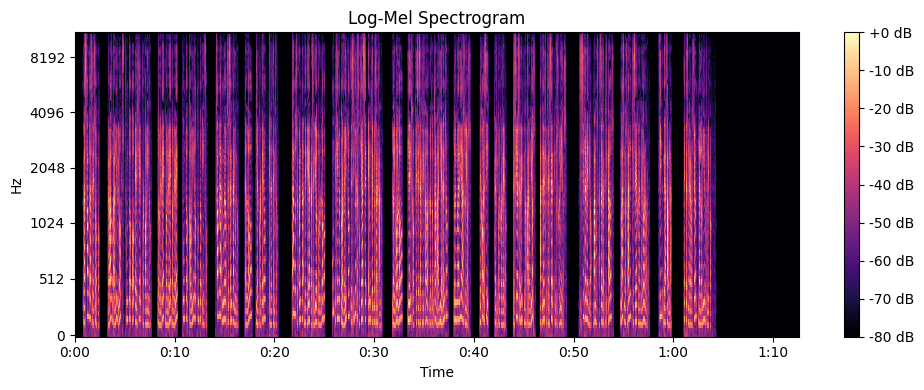

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Cargar un archivo de audio
file_path = "/content/01.mp3"  # o directamente usa uno de los archivos descargados
audio, sr = librosa.load(file_path)

# Calcular el espectrograma mel
S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)

# Convertir a escala logarítmica (dB)
S_dB = librosa.power_to_db(S, ref=np.max)

# Visualizar
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram')
plt.tight_layout()
plt.show()


# **Ejercicio 2b:**

* #### **Eliminar el inicio y final comunes de los textos extraídos de cada fábula.**

* #### **Sugerencia:** Pueden guardar esta información en un archivo tipo JSON, para que al estar probando diferentes opciones en los ejercicios siguientes, puedan recuperar rápidamente la información de cada video/fábula.

In [ ]:
def limpiar_texto(texto):
    texto = re.sub(r'(?si)^.*?fábula número\s*\d+[\.\s,]*', '', texto)
    texto = re.sub(r'(?si)\s*[Ff]in\s*de\s*[la]*\s*f[áa]bula.*$', '', texto)
    return texto.strip()

In [ ]:
cleanFabs = {}
for idx, txtaudio in enumerate(text_audios, start=1):
    cleanFabs[f"fábula_{idx}"] = limpiar_texto(txtaudio)

with open("clean_fabs.json", "w", encoding="utf-8") as f:
    json.dump(cleanFabs, f, ensure_ascii=False, indent=2)

print("=== Guardado clean_fabs.json con", len(cleanFabs), "fábulas.===\n")

for key, text in cleanFabs.items():
    print(f"=== {key} ===\n{text}\n")



=== Guardado clean_fabs.json con 10 fábulas.===

=== fábula_1 ===
El Lobo y el Cordero en el Templo. Dándose cuenta de que era perseguido por un lobo, un pequeño corderito decidió refugiarse en un templo cercano. Lo llamó lobo y le dijo que si el sacrificador lo encontraba allí adentro, lo enmolaría a su dios. Mejor así, replicó el cordero, prefiero ser víctima para un dios a tener que perecer en tus colmillos. Si sin remedio vamos a ser sacrificados, más nos vale que sea con el mayor honor.

=== fábula_2 ===
El lobo y la grulla A un lobo que comía un hueso se le atragantó el hueso en la garganta y corría por todas partes en busca de auxilio. Encontró en su correr a una grulla y le pidió que le salvara de aquella situación y que enseguida le pagaría por ello. Aceptó la grulla e introdujo su cabeza en la boca del lobo, sacando de la garganta el hueso atravesado Pidió entonces la cancelación de la paga convenida Oye, Aniga, dijo el lobo, ¿no crees que es suficiente paga con haber sacado 

# **Ejercicio 3:**

* #### **Apliquen el proceso de limpieza que consideren adecuado.**

* #### **Justifiquen los pasos de limpieza utilizados. Tomen en cuenta que el texto extraído de cada fábula es relativamente pequeño.**

* #### **En caso de que decidan no aplicar esta etapa de limpieza, deberán justificarlo.**

📌 Se optó por realizar los siguientes procesos de limpieza:

* **Eliminación de stopwords**: Se obtienen y eliminan palabras frecuentes del idioma español que suelen repetirse mucho pero no aportar relevancia al contenido del texto, permitiendo a LDA enforarse en temas semánticos reales.

*  **Normalización de espacios**: Se unificaron los espacios dobles o múltiples para evitar errores de tokenizacion para lograr una representación limpia y coherente en el vocabulario.

* **Eliminación de espacios**: Se quitan espacios iniciales y finales para evitar generar tokens vacíos o inconsistentes.

* **Conversión a minúsculas**: Permite estandarizar el texto para que LDA no trate "Perro" y "perro" por ejemplo como palabras distintas, mejorando la coherencia temática.

* **Eliminación de puntiación**: Se remueve puntuación pues suele no aportar significado para los tópicos, posiblemente generando tópicos basura para LDA.

* **Filtrado de tokens**: Se eliminan tokens muy cortos y sin valor semántico, reduciendo ruido y mejorando la calidad de los temas generados por LDA.

In [ ]:
# Incluyan a continuación todas las celdas (de código o texto) que deseen...
nltk.download('stopwords')
mystopwords = stopwords.words('spanish')
print(mystopwords)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
with open("clean_fabs.json", "r", encoding="utf-8") as f:
    raw_fabs = json.load(f)

def clean_fabs(text: str) -> list[str]:
    # Normalizar espacios
    text = re.sub(r'\s+', ' ', text)
    text = text.strip(' ')

    # Convertir a minúsculas
    text = text.lower()

    # Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))


    # Tokenizar
    tokens = text.split()

    # Agregar "sino" a las stopwords específicamente
    extended_stopwords = set(mystopwords)  # Convertir a set para búsqueda más rápida
    extended_stopwords.update(["sino", "¿", "¡", "si","sé"])

    # Filtrar tokens
    tokens = [token for token in tokens
              if len(token) > 1 and token not in extended_stopwords]

    return tokens

In [ ]:
clean_fabs_dict = {
    key: clean_fabs(text)
    for key, text in raw_fabs.items()
}

In [ ]:
for key, tokens in clean_fabs_dict.items():
    print(f"{key} → {tokens}")

fábula_1 → ['lobo', 'cordero', 'templo', 'dándose', 'cuenta', 'perseguido', 'lobo', 'pequeño', 'corderito', 'decidió', 'refugiarse', 'templo', 'cercano', 'llamó', 'lobo', 'dijo', 'sacrificador', 'encontraba', 'allí', 'adentro', 'enmolaría', 'dios', 'mejor', 'así', 'replicó', 'cordero', 'prefiero', 'ser', 'víctima', 'dios', 'tener', 'perecer', 'colmillos', 'remedio', 'vamos', 'ser', 'sacrificados', 'vale', 'mayor', 'honor']
fábula_2 → ['lobo', 'grulla', 'lobo', 'comía', 'hueso', 'atragantó', 'hueso', 'garganta', 'corría', 'todas', 'partes', 'busca', 'auxilio', 'encontró', 'correr', 'grulla', 'pidió', 'salvara', 'aquella', 'situación', 'enseguida', 'pagaría', 'ello', 'aceptó', 'grulla', 'introdujo', 'cabeza', 'boca', 'lobo', 'sacando', 'garganta', 'hueso', 'atravesado', 'pidió', 'entonces', 'cancelación', 'paga', 'convenida', 'oye', 'aniga', 'dijo', 'lobo', '¿no', 'crees', 'suficiente', 'paga', 'haber', 'sacado', 'cabeza', 'sana', 'salva', 'boca', 'nunca', 'hagas', 'favores', 'malvados',

# **Ejercicio 4:**

De cada fábula deberán extraer las palabras clave mediante el algoritmo LDA
(Asignación Latente de Dirichlet). Consideren que cada fábula tiene solo un tópico y
que el total de palabras por tópico serían en principio 20 (pero pueden ajustar este
valor si consideran que obtienen un mejor resultado). Deberán desplegar las
palabras clave obtenidas en cada fábula.

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel

# Crear diccionario a partir del corpus limpio
texts = list(clean_fabs_dict.values())
dictionary = corpora.Dictionary(texts)

# Filtrar palabras muy raras o muy comunes
#dictionary.filter_extremes(no_below=2, no_above=0.8)

# Crear corpus en formato Bag-of-Words
corpus = [dictionary.doc2bow(text) for text in texts]

# Visualizar algunos documentos como ejemplo
print("=== Ejemplo de representación documento-palabra ===")
for i, doc in enumerate(corpus[:2]):
    fable_name = list(clean_fabs_dict.keys())[i]
    print(f"\nFábula: {fable_name}")
    doc_words = [(dictionary[id], freq) for id, freq in doc]
    print(f"Palabras: {doc_words[:10]}...")  # Solo primeras 10 palabras

print("\n" + "="*50)


=== Ejemplo de representación documento-palabra ===

Fábula: fábula_1
Palabras: [('adentro', 1), ('allí', 1), ('así', 1), ('cercano', 1), ('colmillos', 1), ('corderito', 1), ('cordero', 2), ('cuenta', 1), ('decidió', 1), ('dijo', 1)]...

Fábula: fábula_2
Palabras: [('dijo', 1), ('lobo', 4), ('aceptó', 1), ('aniga', 1), ('aquella', 1), ('atragantó', 1), ('atravesado', 1), ('auxilio', 1), ('boca', 2), ('busca', 1)]...



In [ ]:
print("\n=== LDA INDIVIDUAL: Un tópico por fábula ===")
lda_results_individual = {}

for idx, bow in enumerate(corpus):
    fable_id = list(clean_fabs_dict.keys())[idx]

    # Crear modelo LDA para esta fábula específica
    lda_model = LdaModel(
        corpus=[bow],
        num_topics=1,
        id2word=dictionary,
        passes=100,
        random_state=42,
        alpha='auto',
        eta='auto'
    )

    # Extraer palabras del tópico (CORRECCIÓN del error de sintaxis)
    top_words = lda_model.show_topic(0, topn=10)
    lda_results_individual[fable_id] = [word for word, prob in top_words]

# Mostrar resultados individuales
for fable, keywords in lda_results_individual.items():
    print(f"{fable} → {', '.join(keywords)}")

print("\n" + "="*20)



=== LDA INDIVIDUAL: Un tópico por fábula ===
fábula_1 → lobo, dios, cordero, ser, templo, prefiero, sacrificados, perseguido, refugiarse, remedio
fábula_2 → lobo, hueso, paga, grulla, garganta, cabeza, pidió, boca, favores, entonces
fábula_3 → caballo, cebada, lobo, oír, agradaba, amigo, actuar, malvado, masticarla, oídos
fábula_4 → lobo, asno, ley, moviendo, legislar, elegido, escondido, escuchó, hambre, manera
fábula_5 → lobo, cabrito, serenamente, proveen, poderosos, protegido, ocasión, valor, sitio, seguridad
fábula_6 → almeja, huevos, perro, luego, entrañas, acostumbrados, huevo, nunca, dificultades, extrañas
fábula_7 → reflejo, río, ajeno, perro, propio, pedazo, carne, trozo, codicies, arrebatar
fábula_8 → carnicero, perro, clientes, encuentre, cogió, corriendo, ocupado, dejaré, evitarlo, esperes
fábula_9 → campanilla, perro, pública, presumes, presumir, plaza, puso, razón, oculta, sabia
fábula_10 → león, perro, volvió, infeliz, imaginabas, entres, atemorizado, afrontar, mismo, 

# **Ejercicio 5a y 5b:**

* #### **5a: Mediante el LLM que hayan seleccionado, generar un único enunciado que describa o resuma cada fábula.**

* #### **5b: Mediante el LLM que hayan seleccionado, generar tres posibles enunciados diferentes relacionados con la historia de la fábula.**

* #### **Sugerencia:** En realidad los dos incisos a y b se pueden obtener con un solo prompt que solicite la información y el formato correspondiente para cada una de estas partes. Por ejemplo, para cada fábula la salida puede ser un primer enunciado genérico que resume o describe dicha temática; seguido de tres enunciados, cada uno hablando sobre una situación o parte diferente de la fábula.

In [ ]:
# ================================
# 🛠️ Paso 1: Instalar dependencias
# ================================
!pip install -q openai

# ================================
# 🔐 Paso 2: Coloca tu API key de OpenAI
# ================================
import openai
import os

import openai
from google.colab import userdata

openai.api_key = userdata.get("OPENAI_API_KEY")


# ================================
# 📄 Paso 3: Cargar las fábulas limpias
# ================================
import json
import re

with open("clean_fabs.json", "r", encoding="utf-8") as f:
    raw_fabs = json.load(f)

# ================================
# 🤖 Paso 4: Función de resumen + enunciados usando GPT-4
# ================================

from openai import OpenAI

# Crear cliente
client = OpenAI(api_key=openai.api_key)

def obtener_descripcion_y_enunciados_openai(texto_fabula):
    prompt = f"""Eres un experto en literatura infantil. A continuación te doy el texto de una fábula en español.

Quiero que generes:

1. Un enunciado que describa o resuma la temática principal de la fábula.
2. La enseñanza principal de la fábula.
3. Tres enunciados distintos que representen situaciones o momentos importantes de la historia.
4. Una breve sugerencia de 3 a 5 emojis que representen o simbolicen visualmente la historia.

Texto de la fábula: \"\"\"{texto_fabula}\"\"\"

Salida esperada:
Resumen: <una frase descriptiva>
Enseñanza: <una frase con la enseñanza>
Enunciado 1: <primer enunciado>
Enunciado 2: <segundo enunciado>
Enunciado 3: <tercer enunciado>
Sugerencia de emojis: <lista de emojis>
"""

    response = client.chat.completions.create(
        model="gpt-4o-mini",  # Puedes cambiar a "gpt-3.5-turbo"
        messages=[
            {"role": "system", "content": "Eres un asistente útil y creativo."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7,
        max_tokens=500
    )

    return response.choices[0].message.content.strip()


# ================================
# 🚀 Paso 5: Ejecutar por cada fábula
# ================================
resumenes_enunciados = {}

for nombre, texto in raw_fabs.items():
    print(f"🔍 Procesando: {nombre}")

    resultado = obtener_descripcion_y_enunciados_openai(texto)

    resumenes_enunciados[nombre] = resultado
    print(resultado)
    print("="*80)




🔍 Procesando: fábula_1
Resumen: La fábula se centra en un cordero que, al verse acosado por un lobo, decide buscar refugio en un templo, prefiriendo enfrentar un sacrificio honorable a ser devorado por el lobo.

Enseñanza: La fábula nos enseña que, ante situaciones inevitables de peligro o pérdida, es mejor enfrentarlas con dignidad y honor, en lugar de sucumbir ante el miedo.

Enunciado 1: Preso del temor, el pequeño cordero decide refugiarse en un templo para escapar del acecho del lobo.
Enunciado 2: El lobo, tratando de persuadir al cordero, le advierte que si lo encuentran en el templo, será sacrificado a los dioses.
Enunciado 3: El cordero, mostrando valentía, responde que prefiere ser una ofrenda para los dioses antes que ser presa fácil para el lobo.

Sugerencia de emojis: 🐺 (lobo), 🐑 (cordero), 🏛️ (templo), 🔪 (sacrificio), 💪 (valentía).
🔍 Procesando: fábula_2
Resumen: Esta fábula gira en torno a una grulla que ayuda a un lobo a quitar un hueso atragantado en su garganta, y las 

# **Ejercicio 6:**

* #### **Incluyan sus conclusiones de la actividad audio-a-texto:**



- Esta actividad nos ha permitido aplicar modelos de reconocimiento automático de voz para transcribir archivos de audio (Como fue el caso de fábulas de Esopo) con precisión aceptable. La selección del modelo Whisper de Hugging Face, adaptado a las restricciones de hardware y multilingüismo, fue adecuada para obtener una base textual de calidad para tareas posteriores.


- Es evidente que el proceso de limpieza y preprocesamiento es fundamental aún en escenarios de estas características, como eliminación de puntuación, conversión a minúsculas, y eliminación de stopwords, lo cual es esencial para garantizar buenos resultados en técnicas posteriores como el modelado de temas.


- En cuanto al modelado de temas, se utilizó LDA para identificar temas latentes dentro de las fábulas fue una elección acertada. Se logró una agrupación temática que facilitó la comprensión semántica del contenido de los audios. Este caso demustra la utilidad de LDA para resumir o categorizar grandes volúmenes de texto, incluso cuando provienen de transcripciones.


- La segunda parte del ejercicio se enfocó en aprovechar modelos de lenguaje para realizar tareas más avanzadas como resúmenes automáticos o generación de texto relacionado. Esta actividad evidencia la potencia de los LLMs actuales para extraer significado, sintetizar información y generar lenguaje coherente a partir de insumos diversos, como lo son las fábulas clásicas.

# **Fin de la actividad LDA y LMM: audio-a-texto**